In [31]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import pyart

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from metpy.calc import reduce_point_density
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot
import matplotlib.patheffects as path_effects


from siphon.simplewebservice.ndbc import NDBC
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import matplotlib
import metpy
from siphon.catalog import TDSCatalog
import xarray as xr
import netCDF4
from datetime import datetime, timedelta
from io import StringIO
from urllib.request import urlopen
from metpy.io import metar
from metpy.plots import declarative
from metpy.units import units
from metpy.plots import USCOUNTIES

from tropycal import realtime
from geopy.distance import geodesic
import boto3
import botocore
from botocore.client import Config

In [32]:
# List current storms
realtime_obj = realtime.Realtime()
storm_list = realtime_obj.storms
storm_list

--> Starting to read in current storm data
--> Completed reading in current storm data (4.35 seconds)


['AL062024', 'AL922024']

In [33]:
realtime_obj = realtime.Realtime()
storm = realtime_obj.get_storm('AL062024')
now = storm.get_realtime_info()

--> Starting to read in current storm data
--> Completed reading in current storm data (3.76 seconds)


In [34]:
df_radars = pd.read_csv('NEXRAD_sites.csv')

# Format radar file
rad_lats = []
rad_lons = []

for i in np.arange(0, len(df_radars), 1):
    if df_radars.iloc[i]['WKT'][:5] == 'POINT':
    #if type(df_radars.iloc[i]['name']) is str:
        latlon = df_radars.iloc[i].WKT[7:-1].split()
        lo = float(latlon[0])
        la = float(latlon[1])
        rad_lons.append(lo)
        rad_lats.append(la)
    else:
        rad_lons.append(np.nan)
        rad_lats.append(np.nan)

df_radars['Lon'] = rad_lons
df_radars['Lat'] = rad_lats

df_radars = df_radars.dropna()
df_radars = df_radars.reset_index(drop=True)

In [35]:
dist = []
hur_coords = (now['lat'], now['lon'])
for g in np.arange(0, len(df_radars), 1):
    rad_coords = (df_radars['Lat'][g], df_radars['Lon'][g])
    d = geodesic(hur_coords, rad_coords).km
    dist.append(d)
    
df_radars['dist'] = dist

# Find the closest radar
ind = df_radars['dist'].nsmallest(1).index[-1]
site = df_radars.iloc[ind]['name']

# Get current time
current_time = datetime.utcnow()
c_year = current_time.year
if current_time.month < 10:
    c_month = f'0{current_time.month}'
else:
    c_month = current_time.month
if current_time.day < 10:
    c_day = f'0{current_time.day}'
else:
    c_day = current_time.day

In [36]:
s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED,
                                        user_agent_extra='Resource'))
bucket = s3.Bucket('noaa-nexrad-level2')
file_list = []
for obj in bucket.objects.filter(Prefix=f'{c_year}/{c_month}/{c_day}/{site}/'):
    file_list.append(obj.key)

### Use py3 environment

In [37]:
manual = 0

In [38]:
if manual == 1:
    radar_site = 'KVAX'
    rad_file = 'KVAX20230830_160444_V06'
else:
    radar_site = site
    rad_file = file_list[len(file_list)-1][16:]
    if rad_file[-1:] == 'M':
        rad_file = file_list[len(file_list)-2][16:]

In [39]:
aws_nexrad_level2_file = (
    f"s3://noaa-nexrad-level2/{c_year}/{c_month}/{c_day}/{radar_site}/{rad_file}"
)

In [40]:
radar = pyart.io.read_nexrad_archive(aws_nexrad_level2_file)

In [41]:
list(radar.fields)

['differential_phase',
 'spectrum_width',
 'reflectivity',
 'velocity',
 'differential_reflectivity',
 'clutter_filter_power_removed',
 'cross_correlation_ratio']

In [42]:
time = datetime.utcnow()

#date = datetime(2023, 8, 28, 19)
if time.minute < 15:
    date = datetime(time.year, time.month, time.day, time.hour)
else:
    date = datetime(time.year, time.month, time.day, time.hour)

# Remote Access - Read current METAR files
data = StringIO(urlopen('http://bergeron.valpo.edu/current_surface_data/'
                       f'{date:%Y%m%d%H}_sao.wmo').read().decode('utf-8', 'backslashreplace'))
# Local Access
#data = f'/data/ldmdata/surface/sao/{date:%Y%m%d%H}_sao.wmo'

df_metar = metar.parse_metar_file(data, year=date.year, month=date.month)

df_buoy = NDBC.latest_observations()

In [43]:
# Drop rows with missing winds
df_metar_drop = df_metar.dropna(how='any', subset=['wind_direction', 'wind_speed'])
df_buoy_drop = df_buoy.dropna(how='any', subset=['wind_direction', 'wind_speed'])

In [44]:
proj = ccrs.LambertConformal(central_latitude=45., central_longitude=-90.,
                             standard_parallels=[30, 60])
point_locs = proj.transform_points(ccrs.PlateCarree(), df_metar_drop['longitude'].values,
                                   df_metar_drop['latitude'].values)
df_metar_drop_red = df_metar_drop[reduce_point_density(point_locs, 30000.)]
#df_metar_drop_red = df_metar_drop
point_locs = proj.transform_points(ccrs.PlateCarree(), df_buoy_drop['longitude'].values,
                                   df_buoy_drop['latitude'].values)
df_buoy_drop_red = df_buoy_drop[reduce_point_density(point_locs, 30000.)]

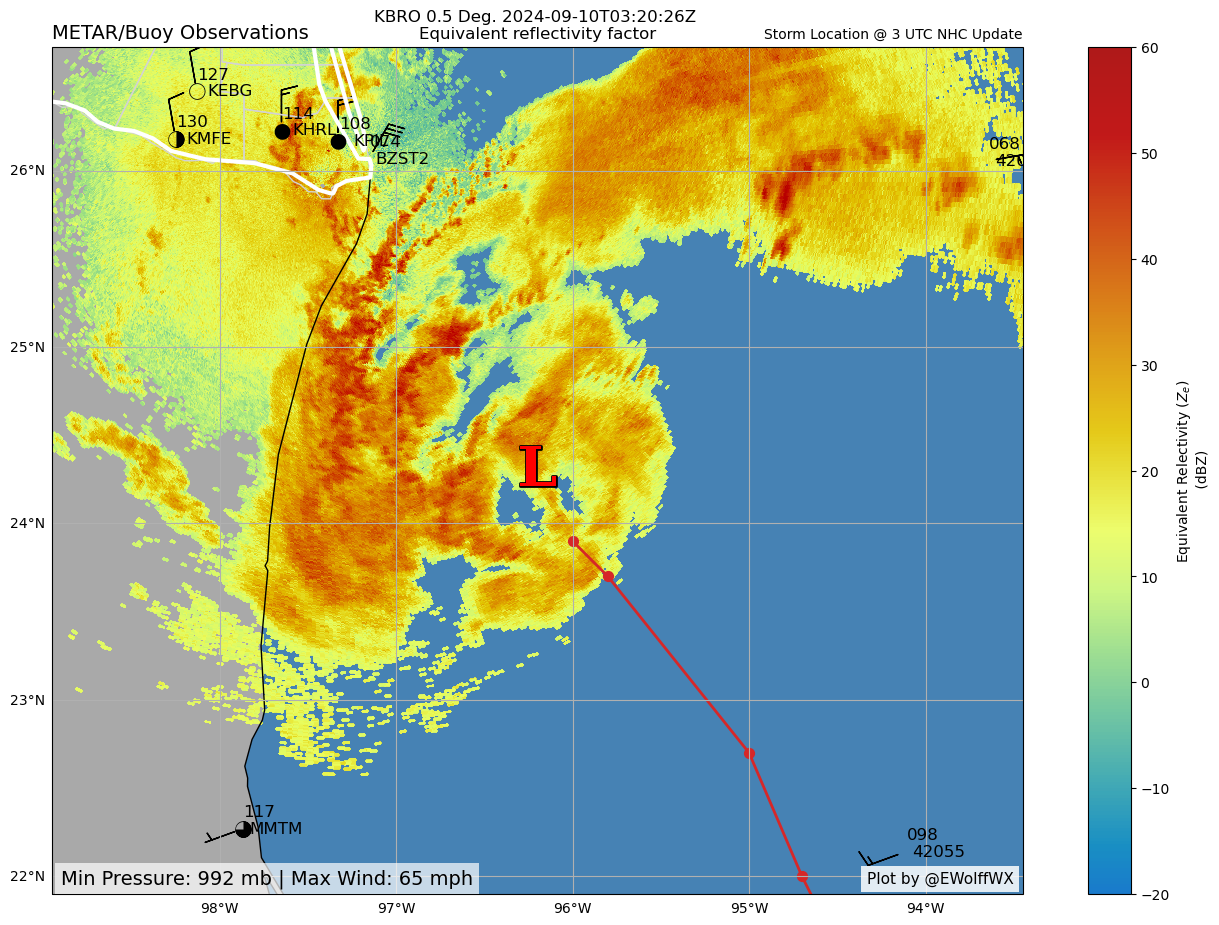

In [45]:
system_lat = now['lat']
system_lon = now['lon']
min_pressure = now['mslp']
max_wind = now['wind_mph']
low_time = f'{now["time_utc"].hour} UTC'

buoy = 'True'
asos = 'True'


###############
proj = ccrs.LambertConformal(central_latitude=45., central_longitude=-90.,
                             standard_parallels=[30, 60])
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(17., 11.), facecolor='white')
ax = plt.axes(projection=proj)
ax.coastlines('50m', edgecolor='w')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='steelblue')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='darkgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='w', linewidth=3)
#ax.set_extent([-87, -81.5, 26.2, 31], ccrs.PlateCarree())
lon_min = system_lon-2.75
lon_max = system_lon+2.75
lat_min = system_lat-2.4
lat_max = system_lat+2.4
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())


la = round(system_lat)
lo = round(system_lon)

display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "reflectivity",
    sweep=0,
    ax=ax,
    colorbar_label="Equivalent Relectivity ($Z_{e}$) \n (dBZ)",
    vmin=-20,
    vmax=60,
    lat_lines = [la-2, la-1, la, la+1, la+2],
    lon_lines = [lo-2, lo-1, lo, lo+1, lo+2],
    alpha=0.9,
    embellish='False',
    resolution='50m',
)

if asos == 'True':
    # Start the station plot by specifying the axes to draw on, as well as the
    # lon/lat of the stations (with transform). We also the fontsize to 12 pt.
    stationplot = StationPlot(ax, df_metar_drop_red['longitude'].values, df_metar_drop_red['latitude'].values,
                            clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

    # Plot the temperature and dew point to the upper and lower left, respectively, of
    # the center point. Each one uses a different color.
    ##stationplot.plot_parameter('NW', df_metar_drop_red['air_temperature'].values, color='red')
    ##stationplot.plot_parameter('SW', df_metar_drop_red['dew_point_temperature'].values, color='darkgreen')

    # A more complex example uses a custom formatter to control how the sea-level pressure
    # values are plotted. This uses the standard trailing 3-digits of the pressure value
    # in tenths of millibars.
    stationplot.plot_parameter('NE', df_metar_drop_red['air_pressure_at_sea_level'].values,
                            formatter=lambda v: format(10 * v, '.0f')[-3:])

    # Plot the cloud cover symbols in the center location. This uses the codes made above and
    # uses the `sky_cover` mapper to convert these values to font codes for the
    # weather symbol font.
    stationplot.plot_symbol('C', df_metar_drop_red['cloud_coverage'].values, sky_cover)

    # Same this time, but plot current weather to the left of center, using the
    # `current_weather` mapper to convert symbols to the right glyphs.
    ##stationplot.plot_symbol('W', df_metar_drop_red['current_wx1_symbol'].values, current_weather)

    # Add wind barbs
    stationplot.plot_barb(df_metar_drop_red['eastward_wind'].values, df_metar_drop_red['northward_wind'].values)

    # Also plot the actual text of the station id. Instead of cardinal directions,
    # plot further out by specifying a location of 2 increments in x and 0 in y.
    stationplot.plot_text((2, 0), df_metar_drop_red['station_id'].values)


if buoy == 'True':
    ###############
    # Start the station plot by specifying the axes to draw on, as well as the
    # lon/lat of the stations (with transform). We also the fontsize to 12 pt.
    stationplot = StationPlot(ax, df_buoy_drop_red['longitude'].values, df_buoy_drop_red['latitude'].values,
                            clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

    # Plot the temperature and dew point to the upper and lower left, respectively, of
    # the center point. Each one uses a different color.
    #stationplot.plot_parameter('NW', df_buoy_drop['air_temperature'].values, color='red')
    #stationplot.plot_parameter('SW', df_buoy_drop['dewpoint'].values,
    #                           color='darkgreen')

    # A more complex example uses a custom formatter to control how the sea-level pressure
    # values are plotted. This uses the standard trailing 3-digits of the pressure value
    # in tenths of millibars.
    stationplot.plot_parameter('NE', df_buoy_drop_red['pressure'].values,
                            formatter=lambda v: format(10 * v, '.0f')[-3:])

    # Plot the cloud cover symbols in the center location. This uses the codes made above and
    # uses the `sky_cover` mapper to convert these values to font codes for the
    # weather symbol font.
    #stationplot.plot_symbol('C', df_metar_drop_red['cloud_coverage'].values, sky_cover)

    # Same this time, but plot current weather to the left of center, using the
    # `current_weather` mapper to convert symbols to the right glyphs.
    #stationplot.plot_symbol('W', df_metar_drop_red['current_wx1_symbol'].values, current_weather)

    east_wind = np.sin(np.deg2rad(df_buoy_drop_red['wind_direction']+180))*df_buoy_drop_red['wind_speed']*1.944
    north_wind = np.cos(np.deg2rad(df_buoy_drop_red['wind_direction']+180))*df_buoy_drop_red['wind_speed']*1.944

    # Add wind barbs
    stationplot.plot_barb(east_wind, north_wind)

    # Also plot the actual text of the station id. Instead of cardinal directions,
    # plot further out by specifying a location of 2 increments in x and 0 in y.
    stationplot.plot_text((2, 0), df_buoy_drop_red['station'].values)
    ###############

plt.plot(storm.lon, storm.lat, transform=ccrs.PlateCarree(), c='tab:red', linewidth=2)
plt.scatter(storm.lon, storm.lat, c='tab:red', s = 50, transform=ccrs.PlateCarree(), 
                 vmin=30, vmax=150)

# Add Low
low_text = plt.text(system_lon, system_lat, 'L', fontsize=40, fontweight='bold', 
        va='center', ha='center', c='red', fontfamily='serif', transform=ccrs.PlateCarree())
#        path_effects=[path_effects.withSimplePatchShadow()])
low_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])

#add_metpy_logo(fig, 10, 10, size='small')
if buoy == 'True' and asos == 'True':
    plt.title('METAR/Buoy Observations', loc='left', fontsize=14)
elif buoy == 'True':
    plt.title('Buoy Observations', loc='left', fontsize=14)
elif asos == 'True':
    plt.title('METAR Observations', loc='left', fontsize=14)
plt.title(f'Storm Location @ {low_time} NHC Update', loc='right', fontsize=10)

t = plt.text(lon_min+0.05, lat_min+0.06, 
            f'Min Pressure: {min_pressure} mb | Max Wind: {max_wind} mph',
            fontweight='medium', transform=ccrs.PlateCarree(), fontsize=14)
t.set_bbox(dict(facecolor='w', alpha=0.7, edgecolor='None'))

t = plt.text(lon_max-0.05, lat_min+0.06, 
            f'Plot by @EWolffWX',
            fontweight='roman', transform=ccrs.PlateCarree(), fontsize=11, ha='right')
t.set_bbox(dict(facecolor='w', alpha=0.85, edgecolor='None'))

# plt.savefig(f'Radar_{radar_site}_{time.year}{time.month}{time.day}_{time.hour}{time.minute}.png', 
#             dpi=200, bbox_inches='tight')
# plt.savefig(f'{now["name"]}_Radar_{radar_site}_{time.year}{time.month}{time.day}_{time.hour}{time.minute}.png',
#             dpi=200, bbox_inches='tight')
plt.show()

In [46]:
# Correct velocity data

# create a gate filter which specifies gates to exclude from dealiasing
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_invalid('velocity')
gatefilter.exclude_invalid('reflectivity')
gatefilter.exclude_outside('reflectivity', 0, 80)

# perform dealiasing
dealias_data = pyart.correct.dealias_region_based(
    radar, gatefilter=gatefilter)
radar.add_field('corrected_velocity', dealias_data)

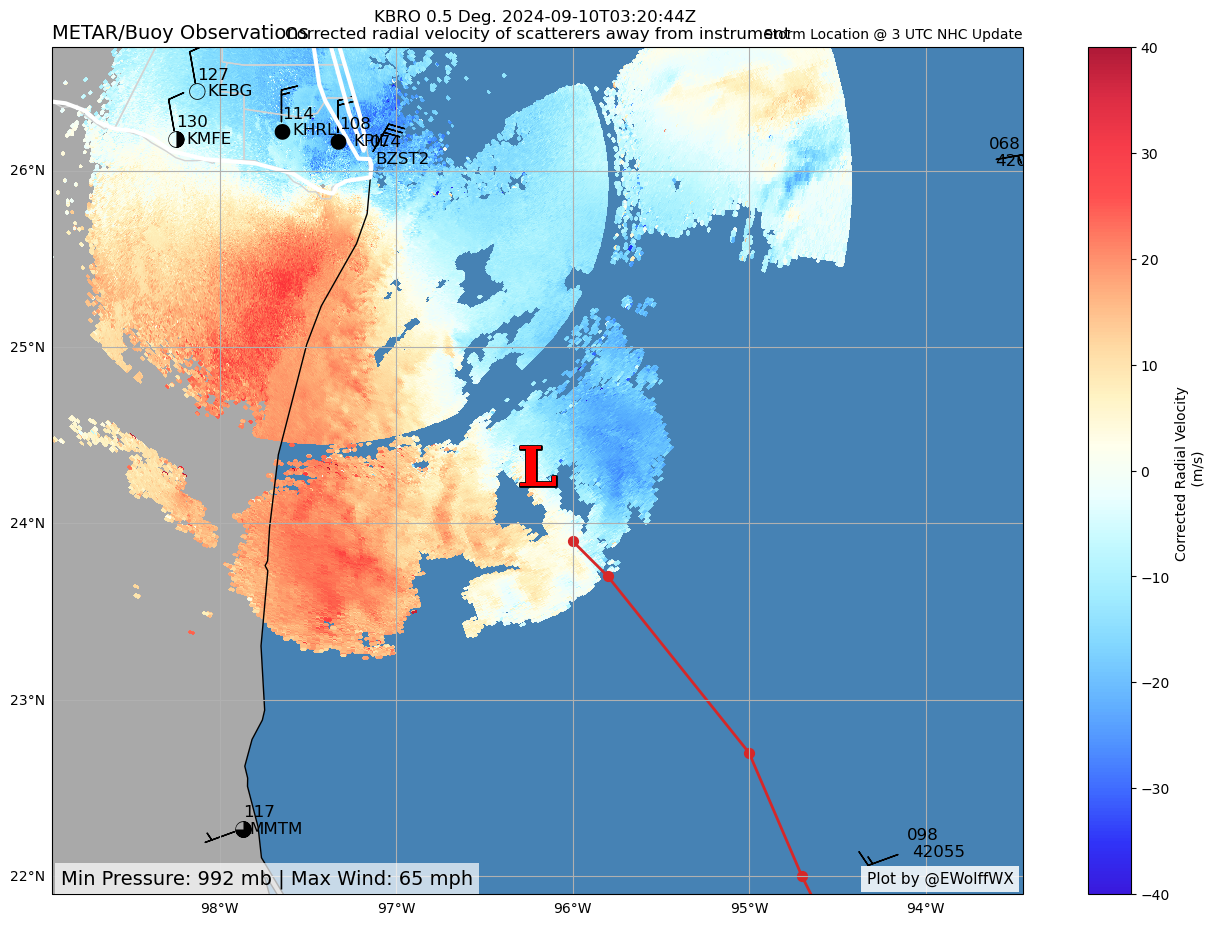

In [49]:
system_lat = now['lat']
system_lon = now['lon']
min_pressure = now['mslp']
max_wind = now['wind_mph']
low_time = f'{now["time_utc"].hour} UTC'

buoy = 'True'
asos = 'True'


###############
proj = ccrs.LambertConformal(central_latitude=45., central_longitude=-90.,
                             standard_parallels=[30, 60])
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(17., 11.), facecolor='white')
ax = plt.axes(projection=proj)
ax.coastlines('50m', edgecolor='w')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='steelblue')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='darkgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='w', linewidth=3)
#ax.set_extent([-87, -81.5, 26.2, 31], ccrs.PlateCarree())
lon_min = system_lon-2.75
lon_max = system_lon+2.75
lat_min = system_lat-2.4
lat_max = system_lat+2.4
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())


la = round(system_lat)
lo = round(system_lon)

display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map(
    "corrected_velocity",
    sweep=1,
    ax=ax,
    colorbar_label="Corrected Radial Velocity \n (m/s)",
    vmin=-40,
    vmax=40,
    lat_lines = [la-2, la-1, la, la+1, la+2],
    lon_lines = [lo-2, lo-1, lo, lo+1, lo+2],
    alpha=0.9,
    embellish='False',
    resolution='50m',
)

if asos == 'True':
    # Start the station plot by specifying the axes to draw on, as well as the
    # lon/lat of the stations (with transform). We also the fontsize to 12 pt.
    stationplot = StationPlot(ax, df_metar_drop_red['longitude'].values, df_metar_drop_red['latitude'].values,
                            clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

    # Plot the temperature and dew point to the upper and lower left, respectively, of
    # the center point. Each one uses a different color.
    ##stationplot.plot_parameter('NW', df_metar_drop_red['air_temperature'].values, color='red')
    ##stationplot.plot_parameter('SW', df_metar_drop_red['dew_point_temperature'].values, color='darkgreen')

    # A more complex example uses a custom formatter to control how the sea-level pressure
    # values are plotted. This uses the standard trailing 3-digits of the pressure value
    # in tenths of millibars.
    stationplot.plot_parameter('NE', df_metar_drop_red['air_pressure_at_sea_level'].values,
                            formatter=lambda v: format(10 * v, '.0f')[-3:])

    # Plot the cloud cover symbols in the center location. This uses the codes made above and
    # uses the `sky_cover` mapper to convert these values to font codes for the
    # weather symbol font.
    stationplot.plot_symbol('C', df_metar_drop_red['cloud_coverage'].values, sky_cover)

    # Same this time, but plot current weather to the left of center, using the
    # `current_weather` mapper to convert symbols to the right glyphs.
    ##stationplot.plot_symbol('W', df_metar_drop_red['current_wx1_symbol'].values, current_weather)

    # Add wind barbs
    stationplot.plot_barb(df_metar_drop_red['eastward_wind'].values, df_metar_drop_red['northward_wind'].values)

    # Also plot the actual text of the station id. Instead of cardinal directions,
    # plot further out by specifying a location of 2 increments in x and 0 in y.
    stationplot.plot_text((2, 0), df_metar_drop_red['station_id'].values)


if buoy == 'True':
    ###############
    # Start the station plot by specifying the axes to draw on, as well as the
    # lon/lat of the stations (with transform). We also the fontsize to 12 pt.
    stationplot = StationPlot(ax, df_buoy_drop_red['longitude'].values, df_buoy_drop_red['latitude'].values,
                            clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

    # Plot the temperature and dew point to the upper and lower left, respectively, of
    # the center point. Each one uses a different color.
    #stationplot.plot_parameter('NW', df_buoy_drop['air_temperature'].values, color='red')
    #stationplot.plot_parameter('SW', df_buoy_drop['dewpoint'].values,
    #                           color='darkgreen')

    # A more complex example uses a custom formatter to control how the sea-level pressure
    # values are plotted. This uses the standard trailing 3-digits of the pressure value
    # in tenths of millibars.
    stationplot.plot_parameter('NE', df_buoy_drop_red['pressure'].values,
                            formatter=lambda v: format(10 * v, '.0f')[-3:])

    # Plot the cloud cover symbols in the center location. This uses the codes made above and
    # uses the `sky_cover` mapper to convert these values to font codes for the
    # weather symbol font.
    #stationplot.plot_symbol('C', df_metar_drop_red['cloud_coverage'].values, sky_cover)

    # Same this time, but plot current weather to the left of center, using the
    # `current_weather` mapper to convert symbols to the right glyphs.
    #stationplot.plot_symbol('W', df_metar_drop_red['current_wx1_symbol'].values, current_weather)

    east_wind = np.sin(np.deg2rad(df_buoy_drop_red['wind_direction']+180))*df_buoy_drop_red['wind_speed']*1.944
    north_wind = np.cos(np.deg2rad(df_buoy_drop_red['wind_direction']+180))*df_buoy_drop_red['wind_speed']*1.944

    # Add wind barbs
    stationplot.plot_barb(east_wind, north_wind)

    # Also plot the actual text of the station id. Instead of cardinal directions,
    # plot further out by specifying a location of 2 increments in x and 0 in y.
    stationplot.plot_text((2, 0), df_buoy_drop_red['station'].values)
    ###############

plt.plot(storm.lon, storm.lat, transform=ccrs.PlateCarree(), c='tab:red', linewidth=2)
plt.scatter(storm.lon, storm.lat, c='tab:red', s = 50, transform=ccrs.PlateCarree(), 
                 vmin=30, vmax=150)

# Add Low
low_text = plt.text(system_lon, system_lat, 'L', fontsize=40, fontweight='bold', 
        va='center', ha='center', c='red', fontfamily='serif', transform=ccrs.PlateCarree())
#        path_effects=[path_effects.withSimplePatchShadow()])
low_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])

#add_metpy_logo(fig, 10, 10, size='small')
if buoy == 'True' and asos == 'True':
    plt.title('METAR/Buoy Observations', loc='left', fontsize=14)
elif buoy == 'True':
    plt.title('Buoy Observations', loc='left', fontsize=14)
elif asos == 'True':
    plt.title('METAR Observations', loc='left', fontsize=14)
plt.title(f'Storm Location @ {low_time} NHC Update', loc='right', fontsize=10)

#plt.title('Corrected Radial Velocity')

t = plt.text(lon_min+0.05, lat_min+0.06, 
            f'Min Pressure: {min_pressure} mb | Max Wind: {max_wind} mph',
            fontweight='medium', transform=ccrs.PlateCarree(), fontsize=14)
t.set_bbox(dict(facecolor='w', alpha=0.7, edgecolor='None'))

t = plt.text(lon_max-0.05, lat_min+0.06, 
            f'Plot by @EWolffWX',
            fontweight='roman', transform=ccrs.PlateCarree(), fontsize=11, ha='right')
t.set_bbox(dict(facecolor='w', alpha=0.85, edgecolor='None'))

# plt.savefig(f'Radar_{radar_site}_{time.year}{time.month}{time.day}_{time.hour}{time.minute}.png', 
#             dpi=200, bbox_inches='tight')
# plt.savefig(f'{now["name"]}_Radar_{radar_site}_{time.year}{time.month}{time.day}_{time.hour}{time.minute}.png',
#             dpi=200, bbox_inches='tight')
plt.show()